# Abstract

Some days ago **Y. O.** present a post about new approach for Tween Segment Extraction (TSE) : https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/142125. The was intresting idea about using Jaccard metric not only as metric, but as loss too: https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/142125#820299. Using Jaccard as loss seems really attractive for me, cause it allows to prevent loss-metric bias (for instance, using BCE only has some disadvantages, explained in next sections). But this idea works only in case of segment prediction (one label "00111100" instead of start_label "00100000" and end label "00000100"), and even in this case we have a problem with continuity property: how to determine predicted segment from arbitrary prediction?<br>
   <br>
    In this notebooks i present two new losses, that seems to be usefull in TSE task:
   - **W**eighted **BCE** (**WBCE**): BCE with taking into account order of items in prediction
   - **J**accard **E**xpectation **L**oss (**JEL**): Using Jaccard metric as loss in "traditional" task formulations with two heads for start and end of text span prediction (with some trick, that i also explain below)
   
Hope you're enjoyng mathematical proofs and improve your results with one of this losses.

**Assumption**: In my opinion, we have strange behavior with competition Jaccard metric, cause of using set() in computation. It means, that, for instance:

$$Jaccard(i \text{ } am \text{ } data \text{ } scientist) = Jaccard(data \text{ } i \text{ } scientist \text{ } am) = 1$$

It looks strange, but that happends rare, cause of $text$ and $selected\_text$ are ordered simbol sequence from the same corpora. So, lets take into account simbol orders:
<br><br>
$$
Jaccard(i \text{ } am \text{ } data \text{ } scientist) = Jaccard(data \text{ } i \text{ } scientist \text{ } am) = 0
$$
$$
Jaccard(i \text{ } am \text{ } data \text{ } scientist) = Jaccard(i \text{ } am \text{ } scientist \text{ } data) = 0.5
$$
$$
Jaccard(i \text{ } am \text{ } data \text{ } scientist) = Jaccard(i \text{ } data \text{ } scientist \text{ } am) = 0.25
$$

This score, i think, have very high correlation with competition Jaccard score, but make our discussion easier.

# Why BCE can works wrong?

Lets consider some of disadvantages of BCE in TSE task.

## Penalty untill ideal prediction

That's what i mean: if at some stage of SGD we have prediction like this
    - true: [0  , 0  , 1  , 0  , 0  , 0  ] (start label or end label)
    - pred: [0.1, 0.1, 0.4, 0.1, 0.2, 0.1]
then this prediction is alredy fine, but obviously $BCE(true, pred) \neq 0$. Moreover, $BCE(true, pred^*) \neq 0$ for each $pred^* \neq true$, that seems way too unnesesarily penalty. It will be good to find some loss $L$, that can get $L(true, pred) \approx 0$ for this example.

##  Order Independence

That's in my opinion more important disadvantage. Examples again:
    - true : [0  , 0  , 1  , 0  , 0  , 0  ]
    - pred1: [0. , 0. , 0.1, 0. , 0. , 0.9]
    - pred2: [0. , 0. , 0.1, 0. , 0.9, 0. ]
    - pred3: [0. , 0. , 0.1, 0.9, 0. , 0. ]
    
Because of index order independence of $BCE$, we get $BCE(true, pred_1) = BCE(true, pred_2) = BCE(true, pred_3)$. But obviously $pred_3$ is the best prediction, cause corresponding Jaccard score is higher then for another predictions. That's bad cause of two reasons:

- BCE loss don't repeat Jaccard score behavior
- This bad BCE property can create some area in model parameters space with constant loss, therefore with null gradient. It means, that in this space there was a lot of local minima (or maxima, or saddle point), that will stop your SGD optimization.

##  Weighted BCE

That's a WBCE comes out time. Lets just spread some potential from true label for making $pred_3$ prediction the best:

    - true      : [0  , 0  , 1, 0  , 0  , 0  ]
    - potential : [0.2, 0.1, 0, 0.1, 0.2, 0.3]
    
and then just weigh BCE vector by this potential vector. We also can tune potential construction:
- different potential factor (0.1 in example - we also can multyply by 0.1 instead of adding)
- biased potential (in example we can try to penalize left errors tougher, then right ones or vice versa)

for getting closer to Jaccard score behavior. But apparenly even optimized WBCE loss will have some fundamental difference from Jaccard score that never vanish.

# Jaccard Expectation Loss

## Denotes

Now i introduce JEL. Lets say we consider one sample and try to predict start and end indexes of text span. Also introduce some natural notation:
- $start\_pred$, $end\_pred$ - text span start/end prediction vectors
- $start$, $end$ - start/end true one-encoding vectors
- $x_{start}$, $x_{end}$ - inex of 1 in true start/end vectors
- $l = length([x_{start}, x_{end}]) = x_{end} - x_{start} + 1 > 0$ - length of true text span

(+1, cause in terns of this competition, length of segement with $x\_start=x\_end$ equals 1)

That OK with four argument dependences for JEL: $$JEL=JEL(start, end, start\_pred, end\_pred)$$ cause 
- $[start\_pred, end\_pred]$ - model output
- $[start, end]$ - true label we can prepare.

Example for understanding:
    - start     : [0  , 1  , 0  , 0  , 0  , 0  ] (x_start = 1)
    - end       : [0  , 0  , 0  , 0  , 1  , 0  ] (x_end = 4)
    - start_pred: [0.1, 0.4, 0.2, 0.1, 0. , 0. ]
    - end_pred  : [0. , 0. , 0.1, 0. , 0.6, 0.2]
    - indexes   : [0  , 1  , 2  , 3  , 4  , 5  ]
    
## Why Expectation?

First problem : we want to get prediction $x_{start}^*$, $x_{end}^*$ for $x_{start}$, $x_{end}$ with vectors $start\_pred$ and $end\_pred$ in way like that

$$x_{start}^* = argmax(start\_pred)$$
$$x_{end}^* = argmax(end\_pred)$$

for getting JEL counting more clear, but $argmax(\cdot)$ function don't differentiable. But insead of tough $argmax(\cdot)$ function we can use methematical expectation:

$$x_{start}^* = E(x_{start}|start\_pred) = <start\_pred, indexes>$$
$$x_{end}^* = E(x_{end}|end\_pred) = <end\_pred, indexes>$$

($indexes$ just a range from 0 till MAX_LEN). Dot product with constant vecor is differentiable, so problem is solved. Some observation:
- For prevent training-inference bias we have to use similar approach for getting prediction from probability vector at inference time.
- If $start\_pred$ or $end\_pred$ near to delta-function (one item equal 1, other equal 0), then expectation equals argmax function. At first glance that's the case of most samples of  $start\_pred$ or $end\_pred$ in practice.

Now it ehough to find JEL function with next dependences:
$$JEL=JEL(x_{start}, x_{end}, x_{start}^*, x_{end}^*)$$



## Major Theory

At this section we will try transform Jaccard score fucntion:
$$Jaccard = \frac{length(Intersection)}{length(Union)}$$

as a differentiable loss with as similar behavior as possible. So, our aim is to get some differentiable function $Jaccard^*$:

$$Jaccard^* \approx Jaccard$$

and then denote $JEL = 1 - Jaccard^*$ and use this loss for model fitting.

### Case $x_{start}^* \leq x_{end}^*$.

#### Subcase $[x_{start}, x_{end}] \cap [x_{start}^*, x_{end}^*] \neq \varnothing  $.

Case images for better understanding:

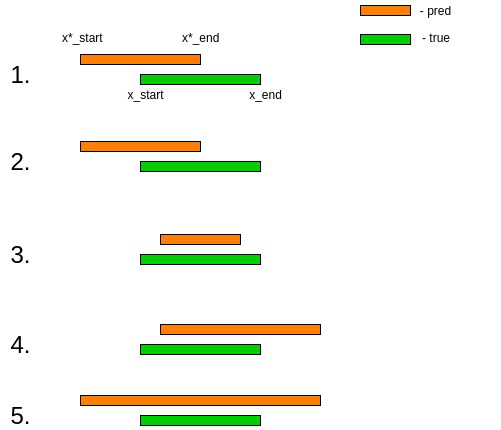

In [1]:
from PIL import Image
Image.open('./Case1.jpg')

In this case $Union$ and $Intersection$ for Jaccard score is a segments (as opposed to the case $[x_{start}, x_{end}] \cap [x_{start}^*, x_{end}^*] = \varnothing $, when union is a tuple of segments). So, formula in terms of current denotes absolutely clear:

$$length(Intersection) = min(x_{end}, x^*_{end}) - max(x_{start}, x^*_{start}) + 1$$
$$length(Union) = max(x_{end}, x^*_{end}) - min(x_{start}, x^*_{start}) + 1$$

except the fact, that $max(\cdot)$ and $min(\cdot)$ functions don't differentiable and therefore we cannot use it. But we can use next trick for achieve differentiability:

$$max(a, b) = a + Relu(b - a)$$
$$min(a, b) = a - Relu(a - b)$$

This trick helps to make Jaccard score differentiable too:

$$
Jaccard
= \frac{length(Intersection)}{length(Union)}
= \frac{min(x_{end}, x^*_{end}) - max(x_{start}, x^*_{start}) + 1}
       {max(x_{end}, x^*_{end}) - min(x_{start}, x^*_{start}) + 1}
= \frac{[x_{end} - Relu(x_{end} - x^*_{end})] - [x_{start} + Relu(x^*_{start} - x_{start})] + 1}
       {[x_{end} + Relu(x^*_{end} - x_{end})] - [x_{start} - Relu(x_{start} - x^*_{start})] + 1}
$$

With $l = x_{end} - x_{start} + 1$ we get:

$$
Jaccard^*
= \frac{l - Relu(x_{start}^* - x_{start}  ) - Relu(x_{end}   - x_{end}^*)}
       {l + Relu(x_{start}   - x_{start}^*) + Relu(x_{end}^* - x_{end})}. 
$$

#### Subcase $[x_{start}, x_{end}] \cap [x_{start}^*, x_{end}^*] = \varnothing  $.

There is only two cases (now $Union$ of segments has two different segements):

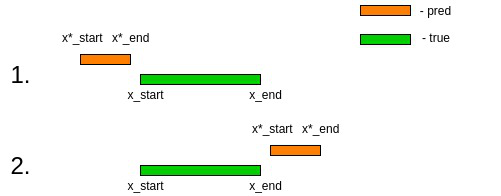

In [2]:
Image.open('./Case2.jpg')

Now $Union$ of segments has two different segements, separate with some gap with length $\xi > 0$. <br>
<br>
Lets consider case $x^*_{start} \leq x^*_{end} \leq x_{start} \leq x_{end}$. In this case gap is $\xi = x_{start} - x^*_{end} > 0$. Compute Relu functions:

$$Relu(x_{start}^* - x_{start}) = Relu(x_{end}^* - x_{end}) = 0$$
$$Relu(x_{start} - x_{start}^*) = x_{start} - x_{start}^*$$
$$Relu(x_{end} - x_{end}^*) = x_{end} - x_{end}^*$$

And put into Jaccard score formula:

$$
Jaccard^*
= \frac{l - 0 - (x_{end} - x_{end}^*)}
       {l + (x_{start}   - x_{start}^*) + 0}
= \frac{l + x_{end}^* - x_{end}    }
       {l + x_{start} - x_{start}^*} 
= \frac{l + x_{end}^* - x_{start} + x_{start} - x_{end}}
       {l + x_{start} - x_{start}^*}
= \frac{l - \xi  - (l - 1)}
       {l + x_{start} - x_{start}^*}
= \frac{1 - \xi}
       {l + x_{start} - x_{start}^*}
$$

That's really attractive result, and thats why:
- if $x_{end}^*$ is integer, so in corner case we have $\xi = 1$ and $Jaccard^*=Jaccard=0$. In case of continuos $x_{end}^*$ near to $x_{start}$ we can get some small positive numbers, when $\xi \approx 0$, but there is small possibility for this continuos case.
- in cases with with gap $\xi > 1$ we get something better, then $Jaccard=0$, we get .. negative $Jaccard^*$! That's relly smart benavior, cause now we can separate "bad cases" from "so so bad cases". And more importantly, we get correct derivative for our loss, so we can make a step from "so so bad case" to "bad case" in SGD process (as describe in sections above, BCE can't do that even in $Jaccard > 0$ cases).

Case $x_{start} \leq x_{end} \leq x_{start}^* \leq x_{end}^*$ with $\xi = x^*_{start} - x_{end} > 0$ exactly the same:
<br>

$$Relu(x_{start} - x_{start}^*) = Relu(x_{end} - x_{end}^*) = 0$$
$$Relu(x_{start}^* - x_{start}) = x_{start}^* - x_{start}$$
$$Relu(x_{end}^* - x_{end}) = x_{end}^* - x_{end}$$
<br>

$$
Jaccard
= \frac{l - (x_{start}^* - x_{start}) - 0}
       {l + 0 + (x_{end}^* - x_{end})} 
= \frac{l - (x_{start}^* - x_{start})}
       {l + (x_{end  }^* - x_{end  })} 
= \frac{l - (x_{start}^* - x_{end} + x_{end} - x_{start})}
       {l + (x_{end  }^* - x_{end  })} 
= \frac{l - (\xi + (l - 1))}
       {l + (x_{end  }^* - x_{end  })} 
= \frac{1 - \xi}
       {l + (x_{end  }^* - x_{end  })} 
$$

### Case $x_{start}^*$ > $x_{end}^*$.

Let proof, that in this case $Jaccard^* \leq 0$ again, but now in geometric manner. It enough to proove, tnat numerator is negative (cause deniminator is positive in each cases): 

$$
l - Relu(x_{start}^* - x_{start}) - Relu(x_{end} - x_{end}^*) \leq 0
$$
or
<br>
$$
Relu(x_{start}^* - x_{start}) + Relu(x_{end} - x_{end}^*) \geq l
$$

Let's go. True label split all space into 3 zones:

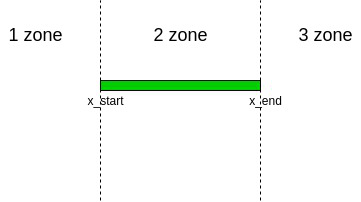

In [3]:
Image.open('./Case3.jpg')

Lets prove this case in three steps:

1. If $x_{start}^*$ is in zone 3 (except board), then proof is over, cause of $Relu(x_{start}^* - x_{start}) > l$. Similary if $x_{end}^*$ is in zone 1 (except board), proof is over again cause of $Relu(x_{end}- x_{end}^*) > l$. Now lets say, that $x_{start}^*$ is not in zone 1, and $x_{end}^*$ is not in zone 1.
<br><br>
2. Case with $x_{start}^*$ in zone 1 imposible, cause it means, that $x_{end}^*$ in zone 1 too cause of $x_{end}^* \leq x_{start}^*$. Similary case with $x_{end}^*$ in zone 3 imposible too.
<br><br>
3. Now we have only one case , when $x_{start}^*$ and $x_{end}^*$ are in zone 2. In this case all relu functions is positive and finally we get (using inequality $x_{start}^* \neq x_{end}^*$):
<br><br>
$$
Relu(x_{start}^* - x_{start}) + Relu(x_{end}   - x_{end}^*) = (x_{start}^* - x_{start}) + (x_{end}   - x_{end}^*) = (x_{start}^* - x_{end}^*) + (x_{end} - x_{start}) \geq 1 + (l - 1) = l
$$

(another comment: in continuos case with small possibility $0 < x_{start}^* - x_{end}^* < 1$)

### Theoretical Conclusion

Proof is over. Finnally we get one formula for all cases:
<br>
$$
Jaccard^*
= \frac{l - Relu(x_{start}^* - x_{start}  ) - Relu(x_{end}   - x_{end}^*)}
       {l + Relu(x_{start}   - x_{start}^*) + Relu(x_{end}^* - x_{end})}. 
$$
wich has a lot of advantages:
- Absolutely equal competition Jaccard score, when it's possible to compute.
- When $Jaccard = 0$, $Jaccard^* <= 0$ and push us into correct area in SGD.
- When prediction is incorrect (left boarder prediction bigger then right one) $Jaccard <= 0$ again! So, maybe we finally get good submission even without postprocessing.
- Denominator for this formula is always positive, so we can compute it for every sample without some lousy NaN's during training. Moreover denominator $ \geq l \geq 1$, so we get computationally robust formula even in theory area, so we haven't add some litle numbers in denimunator in practice.

## Implementation

Now implement JEL with this formula:

$$
Jaccard^*
= \frac{l - Relu(x_{start}^* - x_{start}  ) - Relu(x_{end}   - x_{end}^*)}
       {l + Relu(x_{start}   - x_{start}^*) + Relu(x_{end}^* - x_{end})}. 
$$

**Note**: We concatenate two output vectors with start and end probabilities in one row, so $y\_true$ and $y\_pred$ have 2 * MAX_LEN dimensionality.

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Concatenate, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import models
tf.compat.v1.disable_eager_execution() # for tf placeholders

def jaccard_expectation_loss(y_true, y_pred):
    batch_size, max_len = K.shape(y_true)[0], K.shape(y_true)[1] // 2
    start_true, end_true = y_true[:, :max_len], y_true[:, max_len:]
    start_pred, end_pred = y_pred[:, :max_len], y_pred[:, max_len:]
    
    # for true labels we can use argmax() function, cause labels don't involve in SGD
    x_start = K.cast(K.argmax(start_true, axis=1), dtype=tf.float32)
    x_end   = K.cast(K.argmax(end_true  , axis=1), dtype=tf.float32)
    l = x_end - x_start + 1
    
    # some magic for getting indices matrix like this: [[0, 1, 2, 3], [0, 1, 2, 3]] 
    ind_row = tf.range(0, max_len, dtype=tf.float32)
    ones_matrix = tf.ones([batch_size, max_len], dtype=tf.float32)
    ind_matrix = ind_row * ones_matrix
    
    # expectations for x_start^* (x_start_pred) and x_end^* (x_end_pred)
    x_start_pred = K.sum(start_pred * ind_matrix, axis=1)
    x_end_pred   = K.sum(end_pred   * ind_matrix, axis=1)
    
    relu11 = K.relu(x_start_pred - x_start)
    relu12 = K.relu(x_end   - x_end_pred  )
    relu21 = K.relu(x_start - x_start_pred)
    relu22 = K.relu(x_end_pred   - x_end  )
    
    intersection = l - relu11 - relu12
    union = l + relu21 + relu22
    jel = intersection / union
    
    return 1 - jel

Generate some correct true labels and arbitrary prediction lables:

In [5]:
MAX_LEN = 10
N_BATCH = 5

starts = np.array([np.eye(MAX_LEN)[1]] * N_BATCH).astype(float)
ends   = np.array([np.eye(MAX_LEN)[3][:10]] * N_BATCH).astype(float)
y_true = np.concatenate([starts, ends], axis=1)

y_pred = np.random.rand(N_BATCH, 2 * MAX_LEN)

In [6]:
y_true.shape, y_pred.shape

((5, 20), (5, 20))

And apply the formula:

In [7]:
y_pred_inp = tf.compat.v1.placeholder(tf.float32, shape=[None, 2 * MAX_LEN])
y_true_inp = tf.compat.v1.placeholder(tf.float32, shape=[None, 2 * MAX_LEN])

jel = jaccard_expectation_loss(y_pred_inp, y_true_inp)

sess = tf.compat.v1.Session()
jel = sess.run(jel, feed_dict={y_pred_inp: y_pred, y_true_inp: y_true})
jel

array([1.3333334, 1.1666666, 1.5714285, 0.5      , 3.       ],
      dtype=float32)

It works! Now check correctness.

## Checking Correctness

### Checking Formula

Generate some batch of data with some restrictions:
- True labels are correct (starts smaller, than ends)
- Prediction labels are arbitrary, nut only one-encoding vectors (for being able to compare with original Jaccard score)

In [8]:
def get_rand_discrete_output():
    output = np.zeros(MAX_LEN).astype(int)
    ind = np.random.randint(0, MAX_LEN - 1)
    output[ind] = 1
    return output

def get_discrete_batch(n_batch):
    starts_true, ends_true = [], []
    starts_pred, ends_pred = [], []

    batch_ind = 0
    while batch_ind < N_BATCH:
        starts_true_, ends_true_ = get_rand_discrete_output(), get_rand_discrete_output()
        starts_pred_, ends_pred_ = get_rand_discrete_output(), get_rand_discrete_output()
        if starts_true_.argmax() <= ends_true_.argmax():
            batch_ind += 1
            starts_true += [starts_true_]
            ends_true   += [ends_true_  ]
            starts_pred += [starts_pred_]
            ends_pred   += [ends_pred_  ]
    return np.array(starts_true), np.array(ends_true), np.array(starts_pred), np.array(ends_pred)

In [82]:
N_BATCH = 1

starts_true, ends_true, starts_pred, ends_pred = get_discrete_batch(N_BATCH)
y_true = np.concatenate([starts_true, ends_true], axis=1)
y_pred = np.concatenate([starts_pred, ends_pred], axis=1)

Apply fresh JEL:

In [83]:
sess = tf.compat.v1.Session()
jel_arr = sess.run(
    jaccard_expectation_loss(y_pred_inp, y_true_inp),
    feed_dict={y_pred_inp: y_pred, y_true_inp: y_true}
)
len(jel_arr)

1

Now find original Jaccard scores for the same data. Cause we don't have real texts, we just transform vectors to string, and then apply Jaccard score in next manner: 
    - inp start: [1, 0, 0, 0]
    - inp end  : [0, 0, 1, 0]
    - out str  : " 1 2 3"
(operating only 0 and 1 signs would be incorrect cause of set() using in Jaccard score formula)

In [84]:
def jaccard(str1, str2):
    a = set(str(str1).lower().split()) 
    b = set(str(str2).lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def get_str_output(start, end):
    output = ((start.cumsum() - end[::-1].cumsum()[::-1]) == 0).astype(int)
    output = output * np.arange(1, len(start) + 1)
    return " ".join(output[output > 0].astype(str))

In [85]:
get_str_output(np.array([1, 0, 0, 0]), np.array([0, 0, 1, 0]))

'1 2 3'

Now we can check the formula. Cause of predictions ar arbitrary, there ar three cases:
- [**incorrect prediction**]: $x_{start}^* > x_{end}^*$ . We can check $Jaccard^* \leq 0$.
- [**intersection > 0**]: $x_{start}^* \leq x_{end}^*$, $[x_{start}^*, x_{end}^*] \cap [x_{start}^*, x_{end}^*] = \varnothing$ . Correct prediction, but $Jaccard^* \leq 0$ (but $Jaccard = 0$)
- [**intersection = 0**]: $x_{start}^* \leq x_{end}^*$, $[x_{start}^*, x_{end}^*] \cap [x_{start}^*, x_{end}^*] \neq \varnothing$ . Everything is correct : $Jaccard^* > 0$ (and $Jaccard > 0$)

In [86]:
def checking_formula(eps=0.001):
    for batch_ind in range(N_BATCH):
        x_start0, x_end0 = starts_true[batch_ind].argmax(), ends_true[batch_ind].argmax()
        x_start1, x_end1 = starts_pred[batch_ind].argmax(), ends_pred[batch_ind].argmax()    

        str1 = get_str_output(starts_true[batch_ind], ends_true[batch_ind])
        if x_start1 <= x_end1:
            str2 = get_str_output(starts_pred[batch_ind], ends_pred[batch_ind])
        else:
            str2 = get_str_output(ends_pred[batch_ind], starts_pred[batch_ind])

        out1 = jaccard(str1, str2)
        out2 = 1 - jel_arr[batch_ind]

        if (x_start1 > x_end1):
            case = "incorrrect pred "
            assert out2 <= 0, (str1, str2, out1, out2)
        else:
            if (x_start1 > x_end0) or (x_start0 > x_end1):
                case = "intersection = 0"
                assert out2 <= 0, (str1, str2, out1, out2)
            else:
                case = "intersection > 0"
                assert abs(out1 - out2) < eps, (str1, str2, out1, out2)

        if case == "incorrrect pred ":
            show_str1 = str1.replace(" ", "").ljust(MAX_LEN)
            show_str2 = str2.replace(" ", "").ljust(MAX_LEN)
            print(f'[{case}]: true: {show_str1}, pred: {show_str2}, out1: {out1:.3f}, out2: {out2:.3f}') 

In [87]:
checking_formula(eps=0.001)

[incorrrect pred ]: true: 345678    , pred: 2345      , out1: 0.429, out2: -0.333


It looks good! Assert works even with some comments for continuos cases, when strict proof can go wrong.

### Checking Being Loss

Now check, that our custom loss can be used as Keras loss with some tiny model. It can be wrong if we used some non differentiable functions, or cause of other technical problems. And we also can check decreasing loss during training, that a necessary point, independent of size model.

In [152]:
def smoothed_categorical_crossentropy(y_true, y_pred, label_smoothing=0.1):
    # adjust the targets for sequence bucketing
    ll = tf.shape(y_pred)[1]
    y_true = y_true[:, :ll]
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)

    return tf.reduce_mean(loss)

In [153]:
INIT_VOC_SIZE = 200

inds = np.random.randint(0, VOC_SIZE, size=(N_BATCH, 20))
inp = tf.keras.utils.to_categorical(inds).sum(1)

VOC_SIZE = inds.max() + 1

In [209]:
def get_model(lr=0.01, loss_fn=smoothed_categorical_crossentropy):
    x = Input((VOC_SIZE,), dtype=tf.int32)

    y1 = Dense(MAX_LEN)(x)
    y1 = Activation('softmax')(y1)

    y2 = Dense(MAX_LEN)(x)
    y2 = Activation('softmax')(y2)

    y = Concatenate(axis=1)([y1, y2])

    model1 = models.Model(inputs=x, outputs=y)
    model1.compile(loss=smoothed_categorical_crossentropy, optimizer=SGD(lr))
    
    model2 = models.Model(inputs=x, outputs=y)
    model2.compile(loss=jaccard_expectation_loss, optimizer=SGD(lr))
    
    return [model1, model2]

In [156]:
get_model().summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 159)]        0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 10)           1600        input_13[0][0]                   
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 10)           1600        input_13[0][0]                   
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 10)           0           dense_24[0][0]                   
___________________________________________________________________________________________

Check on some random input data:

In [157]:
inp[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 1.], dtype=float32)

In [158]:
y_true[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [159]:
inp.shape, y_true.shape

((1, 159), (1, 20))

In [160]:
VOC_SIZE

159

In [161]:
y_pred[:MAX_LEN]

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [227]:
def show_results(loss_fn=jaccard_expectation_loss, lr=0.01, n_iter=100):
    inds = np.arange(MAX_LEN)
    models = get_model(lr, loss_fn)

    test_ind = 0
    for i in range(n_iter):
        model = models[0]
        model.fit(inp, y_true, verbose=1)
        y_test_pred = model.predict(inp[[0]])[0]
        y_test_true = y_true[test_ind]
        x_start, x_end = np.argmax(y_test_true[:MAX_LEN]), np.argmax(y_test_true[MAX_LEN:])
        x_start_pred, x_end_pred = sum(y_test_pred[:MAX_LEN] * inds), sum(y_test_pred[MAX_LEN:] * inds)
        print(f'true: [{x_start}, {x_end}], pred: [{x_start_pred:.5f}, {x_end_pred:.5f}]')

In [228]:
show_results(jaccard_expectation_loss, lr=0.001)

Train on 1 samples
1/1 [==============================] - 0s 1ms/sample - loss: 6.5092
true: [2, 7], pred: [4.96402, 4.54334]
Train on 1 samples
1/1 [==============================] - 0s 691us/sample - loss: 6.4756
true: [2, 7], pred: [4.96067, 4.54727]
Train on 1 samples
1/1 [==============================] - 0s 1ms/sample - loss: 6.4421
true: [2, 7], pred: [4.95728, 4.55126]
Train on 1 samples
1/1 [==============================] - 0s 976us/sample - loss: 6.4087
true: [2, 7], pred: [4.95384, 4.55533]
Train on 1 samples
1/1 [==============================] - 0s 683us/sample - loss: 6.3754
true: [2, 7], pred: [4.95036, 4.55947]
Train on 1 samples
1/1 [==============================] - 0s 935us/sample - loss: 6.3422
true: [2, 7], pred: [4.94682, 4.56368]
Train on 1 samples
1/1 [==============================] - 0s 804us/sample - loss: 6.3092
true: [2, 7], pred: [4.94324, 4.56796]
Train on 1 samples
1/1 [==============================] - 0s 663us/sample - loss: 6.2762
true: [2, 7], pred:

1/1 [==============================] - 0s 1ms/sample - loss: 4.6102
true: [2, 7], pred: [4.63652, 4.93230]
Train on 1 samples
1/1 [==============================] - 0s 1ms/sample - loss: 4.5853
true: [2, 7], pred: [4.62934, 4.94021]
Train on 1 samples
1/1 [==============================] - 0s 856us/sample - loss: 4.5606
true: [2, 7], pred: [4.62209, 4.94816]
Train on 1 samples
1/1 [==============================] - 0s 1ms/sample - loss: 4.5361
true: [2, 7], pred: [4.61477, 4.95614]
Train on 1 samples
1/1 [==============================] - 0s 736us/sample - loss: 4.5117
true: [2, 7], pred: [4.60739, 4.96416]
Train on 1 samples
1/1 [==============================] - 0s 1ms/sample - loss: 4.4875
true: [2, 7], pred: [4.59994, 4.97220]
Train on 1 samples
1/1 [==============================] - 0s 1ms/sample - loss: 4.4635
true: [2, 7], pred: [4.59244, 4.98028]
Train on 1 samples
1/1 [==============================] - 0s 775us/sample - loss: 4.4396
true: [2, 7], pred: [4.58487, 4.98838]
Train

In [205]:
show_results(smoothed_categorical_crossentropy, lr=0.1)

Train on 1 samples
1/1 [==============================] - 0s 798us/sample - loss: 6.0761
true: [2, 7], pred: [3.49616, 4.94651]
Train on 1 samples
1/1 [==============================] - 0s 936us/sample - loss: 3.3232
true: [2, 7], pred: [2.77507, 5.97782]
Train on 1 samples
1/1 [==============================] - 0s 745us/sample - loss: 2.3050
true: [2, 7], pred: [2.52131, 6.37452]
Train on 1 samples
1/1 [==============================] - 0s 1ms/sample - loss: 2.0677
true: [2, 7], pred: [2.40177, 6.54000]
Train on 1 samples
1/1 [==============================] - 0s 733us/sample - loss: 1.9839
true: [2, 7], pred: [2.33299, 6.62881]
Train on 1 samples
1/1 [==============================] - 0s 2ms/sample - loss: 1.9441
true: [2, 7], pred: [2.28855, 6.68383]
Train on 1 samples
1/1 [==============================] - 0s 917us/sample - loss: 1.9221
true: [2, 7], pred: [2.25762, 6.72107]
Train on 1 samples
1/1 [==============================] - 0s 2ms/sample - loss: 1.9088
true: [2, 7], pred: [

In [ ]:
model.fit(x, y_true, epochs=2000, verbose=1)

In [98]:
model.predict(x)

array([[ 0.18146323, -0.8405605 ,  0.5620082 , -0.10563993, -0.19898231,
        -0.43483075, -0.01636792, -0.18793613,  0.17881906,  0.35346952,
         0.6353555 , -0.41135448,  0.5678985 , -0.10310794, -0.6630851 ,
         0.3320193 ,  0.16254683,  0.39623684, -0.32077152,  0.04116598],
       [ 0.4071352 , -0.20997676, -0.2923761 ,  0.8232709 , -0.00190281,
        -0.7976111 , -0.29006058, -0.21866107,  0.52923787,  0.7309581 ,
         0.00773066, -0.053238  ,  0.39377034, -0.5272001 ,  0.45411444,
         0.37246466,  0.2771541 , -0.21968889,  0.04935703,  0.40083432],
       [ 0.6579855 ,  0.48571938, -0.36980176, -0.14157563,  0.70516586,
        -0.2512255 ,  0.71752596,  0.04256302,  0.20992506, -0.5581141 ,
         0.5999609 ,  0.1037205 ,  0.10467454, -0.75329053,  0.41576123,
        -0.28564098, -0.3175853 , -0.04740323,  0.20410827,  0.49345034],
       [ 0.19343966, -0.23307209, -0.02969283,  0.0718475 , -0.15977344,
         0.06988633,  0.8652878 , -0.10242667, -

Loss really decrease!

# Conclusion

This notebook introduce two new loss function: Weighted BCE (without implementation) and Jaccard Expectation Loss (with implementation). It needs for eliminate some BCE defects, decribed above, and just for using competition metric as a loss. That's not so easy, cause the metric is sophisticated enough and we need to programm it in differentiable manner. It was hard in sone degree, but we do it! (advantages describing in **Theoretical Conclusion** part).
<br><br>
Hope, this metric will help you to achive good score according to your aim. I don't use it yet, but going to do that this night. Please, let me know if this metric really can help you to get better score, than you already have (or don't helps whatsoever :) ). Good luck!